In [1]:
# Imports & Setup

from libs import *

base_players_dataset = pd.read_csv(PROJECT_FOLDER + 'files/base_players_dataset.csv')

<AxesSubplot:>

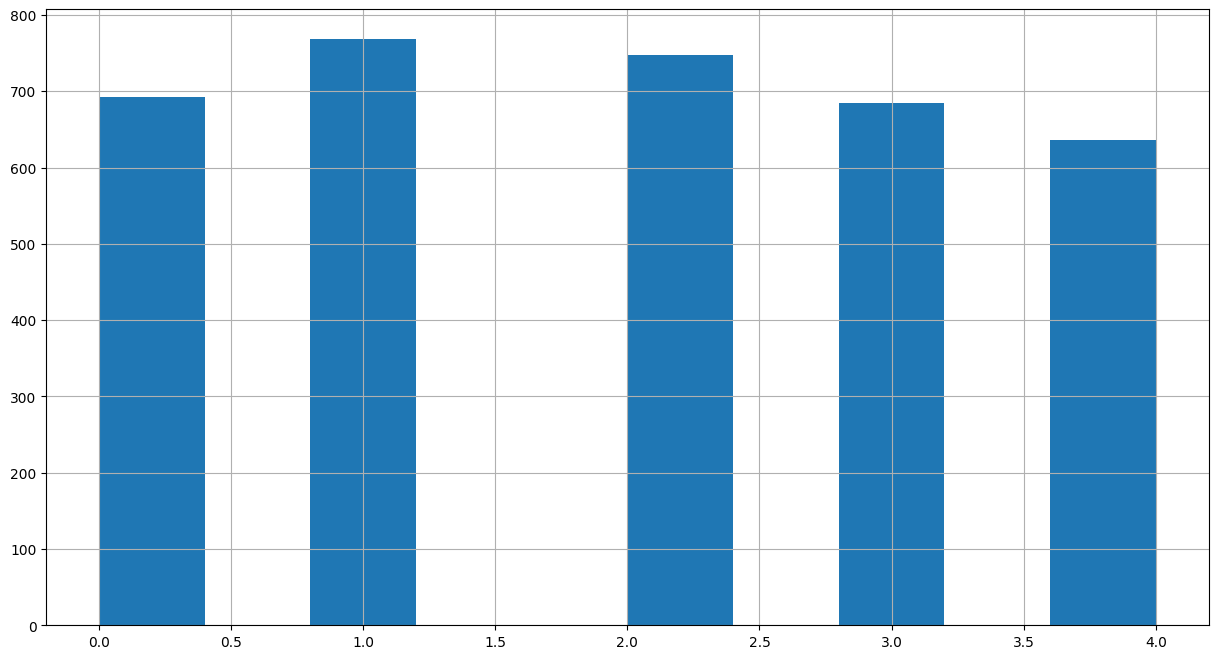

In [2]:
# Prepare df for stratify

value_bins = [-np.inf, -1000000, 0, 500000, 3000000, np.inf]

base_players_dataset['value_cat'] = pd.cut(base_players_dataset["value_diff"], bins=value_bins, labels=range(len(value_bins)-1))

base_players_dataset['value_cat'].hist()

In [3]:
# Create test set

from sklearn.model_selection import train_test_split

players_for_analysis = base_players_dataset[:]

players_for_analysis.dropna(subset=['value_cat'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(players_for_analysis, players_for_analysis['value_diff'], test_size=0.2, random_state=42, stratify=players_for_analysis['value_cat'])

In [4]:
# Revert to clean training set

players_v1 = x_train.drop('value_cat', axis=1)

players_labels_v1 = y_train

In [5]:
# Custom Nation transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
        nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        max_rank = nation_encoder['rank'].max() + 1
        X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        X.drop('Nation', axis=1, inplace=True)
        return X

In [6]:
# Custom Attributes transformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from utils import apply_mean_attribute_list, PLAYER_ATTR

class AttributeMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        physical_attr = ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat']
        mental_attr = ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg']
        apply_mean_attribute_list(X, 'M+P', physical_attr + mental_attr)
        X['M+P'] = X['M+P'] / 20
        X.drop(PLAYER_ATTR, axis=1, inplace=True)
        return X


In [7]:
# Custom Based transformer

from sklearn.base import BaseEstimator, TransformerMixin

class BasedToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        based_encoder = base_players_dataset.groupby('Based').sum().rank(ascending=True, method='first')
        max_rank = based_encoder['value_2020'].max()
        X['Based_rank'] = (X['Based'].map(based_encoder['value_2020']).fillna(max_rank) / max_rank)
        X.drop('Based', axis=1, inplace=True)
        return X

In [8]:
# Custom Foot transformer

from sklearn.base import BaseEstimator, TransformerMixin

class FootToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Foot_rank'] = X['Preferred Foot'].map(FOOTEDNESS_MAPPING)
        X.drop('Preferred Foot', axis=1, inplace=True)
        return X

In [9]:
# Using transformation pipelines

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils import PLAYER_ATTR

players = x_train.drop('Value', axis=1)

features_v1 = {
    'att': (PLAYER_ATTR, ['M+P']),
    'num': (PLAYER_ATTR + ['Age'], None),
    #'foo': (['Preferred Foot'], None),
    #'pos': (['Best Pos'], None),
    'nat': (['Nation'], None),
    'bas': (['Based'], None)
}

feature_labels_v1 = list(np.concatenate([f[1] if f[1] is not None else f[0] for k, f in features_v1.items()]).flat)

full_pipeline_v1 = ColumnTransformer([
    ("att", AttributeMerger(), features_v1['att'][0]),
    ("num", StandardScaler(), features_v1['num'][0]),
    #("foo", FootToRank(), features_v1['foo'][0]),
    #("pos", OneHotEncoder(), features_v1['pos'][0]),
    ("nat", NationToRank(), features_v1['nat'][0]),
    ("bas", BasedToRank(), features_v1['bas'][0])
])

players_prepared_v1 = full_pipeline_v1.fit_transform(players)

In [10]:
# Hyperparameter tuning

import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

try:
    value_predictor_v1 = joblib.load(PROJECT_FOLDER + 'models/rf_value_predictor_reg.pkl')
except:
    rf_param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 20)],
        'max_depth': [int(x) for x in np.linspace(10, 100, num = 5)] + [None],
        'bootstrap': [True, False],
    }

    value_predictor_v1 = RandomForestRegressor()
    value_predictor_v1_grid_search = RandomizedSearchCV(value_predictor_v1, rf_param_grid, cv=20, scoring='neg_mean_squared_error', return_train_score=True, n_iter=10, error_score="raise")

    value_predictor_v1_grid_search.fit(players_prepared_v1, players_labels_v1)

    value_predictor_v1 = value_predictor_v1_grid_search.best_estimator_

    joblib.dump(value_predictor_v1, 'models/rf_value_predictor_reg.pkl')

In [11]:
# Fit model
    
from sklearn.ensemble import RandomForestRegressor

value_predictor_v1.fit(players_prepared_v1, players_labels_v1)

RandomForestRegressor(n_estimators=352)

In [12]:
value_predictions_v1 = value_predictor_v1.predict(players_prepared_v1)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, value_predictions_v1, squared=False)

3007726.5840352518

In [13]:
train_players_v1 = x_train[:]
train_players_v1['Predicted'] = value_predictions_v1.round()
train_players_v1 = train_players_v1[['value_diff', 'Predicted']]

<BarContainer object of 40 artists>

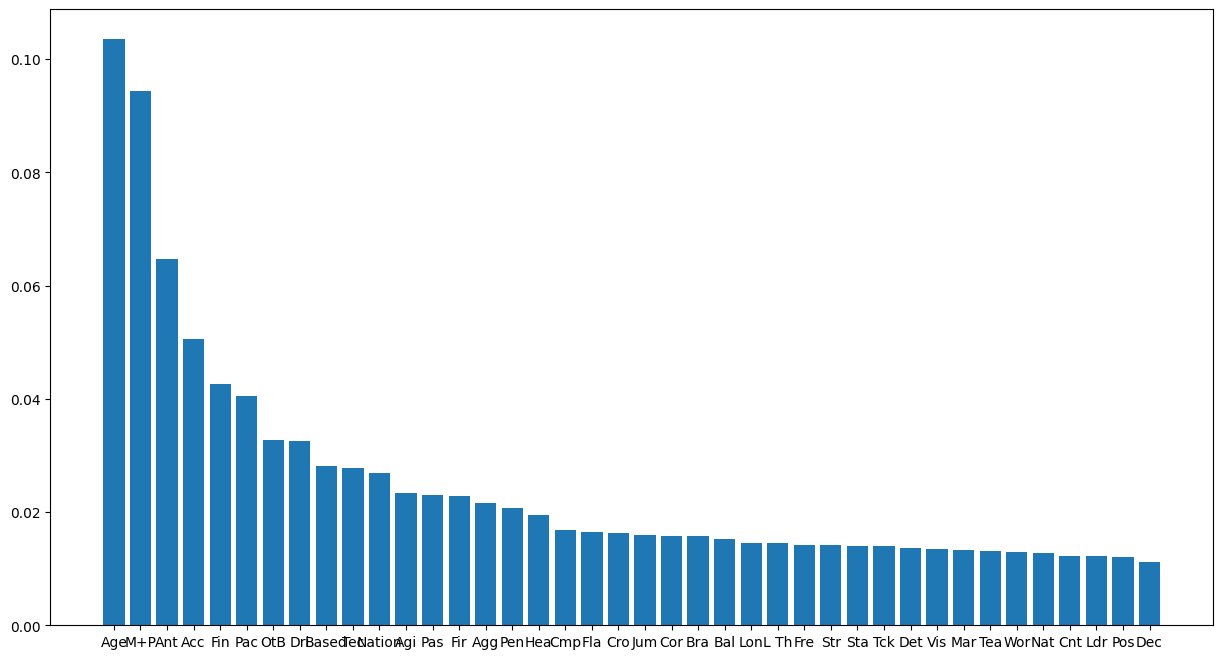

In [14]:
from utils import same_sort

feature_importances_v1, feature_labels_v1 = same_sort(value_predictor_v1.feature_importances_, feature_labels_v1, reverse=True)

plt.bar(feature_labels_v1, feature_importances_v1)

In [15]:
# Prepare test values for analysis

test_players_prepared = full_pipeline_v1.fit_transform(x_test)
test_players_labels = y_test

In [16]:
# Test values confusion matrix

test_value_predictions_v1 = value_predictor_v1.predict(test_players_prepared)

In [17]:
# Try with test model

test_players_v1 = x_test[['Name', 'Age', 'Position', 'Club', 'PA', 'value_diff']]
test_players_v1['pred'] = test_value_predictions_v1

mean_squared_error(y_test, test_value_predictions_v1, squared=False)

# test_total_value_without_model = test_players_v1['value_diff'].sum()
# test_total_value_with_model = test_players_v1.query('pred == 1')['value_diff'].sum()
# test_max_value_without_model = test_players_v1.query('value_diff > 0')['value_diff'].sum()

# test_performance = (test_total_value_with_model - test_total_value_without_model) / test_total_value_without_model
# max_test_performance = (test_max_value_without_model - test_total_value_without_model) / test_total_value_without_model

# print("Perf:", test_performance)
# print("Max Perf:", max_test_performance)
# print("Value diff from max:", test_max_value_without_model - test_total_value_with_model)

7477119.281835904